df_clean satır: 36

--- PERFORMANS (TEST: 1-adım ahead) ---
MSE  : 29.8350
RMSE : 5.4621
MAE  : 4.6671
MAPE : 6.77%


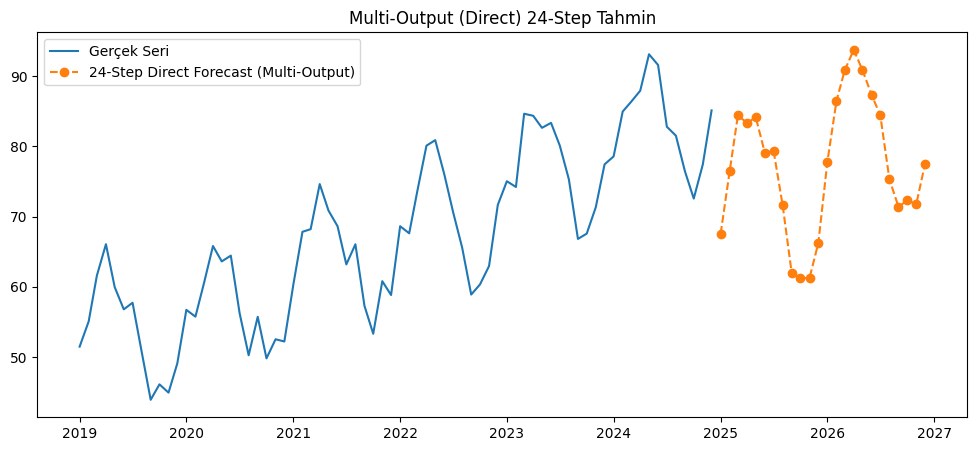

,0
2025-01-01,67.566607
2025-02-01,76.520004
2025-03-01,84.411707
2025-04-01,83.317513
2025-05-01,84.122822
2025-06-01,79.098969
2025-07-01,79.353112
2025-08-01,71.602734
2025-09-01,61.950118
2025-10-01,61.212627


In [1]:
# ================================================================
#   MULTI-OUTPUT (DIRECT MULTI-STEP) FORECAST — 24 AY
#   Tek hücre — PERFORMANS METRİKLİ VERSİYON
# ================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error

# ----------------------------------------------------------
# 1) SENTETİK VERİ (72 adet)
# ----------------------------------------------------------
np.random.seed(42)
periods = 72

dates = pd.date_range(start="2019-01-01", periods=periods, freq="MS")
trend = 0.5 * np.arange(periods)
seasonal = 10 * np.sin(2 * np.pi * np.arange(periods) / 12)
noise = np.random.normal(scale=3.0, size=periods)
base = 50

prices = base + trend + seasonal + noise
series = pd.Series(prices, index=dates, name="price")

# ----------------------------------------------------------
# 2) LAG (1..12) + HORIZON (1..24)
# ----------------------------------------------------------
max_lag = 12
forecast_horizon = 24

df = pd.DataFrame(series)

# lag özellikleri
for lag in range(1, max_lag + 1):
    df[f"lag_{lag}"] = df["price"].shift(lag)

# multi-output hedefler
for step in range(1, forecast_horizon + 1):
    df[f"target_t_plus_{step}"] = df["price"].shift(-step)

df_clean = df.dropna().copy()
print("df_clean satır:", df_clean.shape[0])  # 36 beklenir

# ----------------------------------------------------------
# 3) TRAIN–TEST SPLIT
# ----------------------------------------------------------
train_size = df_clean.shape[0] - 12   # 36 - 12 = 24
test_size  = 12

train = df_clean.iloc[:train_size]
test  = df_clean.iloc[train_size:]

X_train = train[[f"lag_{i}" for i in range(1, max_lag + 1)]].values
Y_train = train[[f"target_t_plus_{i}" for i in range(1, forecast_horizon + 1)]].values

X_test  = test[[f"lag_{i}" for i in range(1, max_lag + 1)]].values
Y_test_1 = test["target_t_plus_1"].values    # performans hesaplaması için (1-adım gerçekleri)

# ----------------------------------------------------------
# 4) MODEL
# ----------------------------------------------------------
model = MultiOutputRegressor(LinearRegression())
model.fit(X_train, Y_train)

# ----------------------------------------------------------
# 5) 24 AYLİK DIRECT FORECAST
# ----------------------------------------------------------
last_input = X_test[-1].reshape(1, -1)
pred_24 = model.predict(last_input)[0]

forecast_dates = pd.date_range(
    start=series.index[-1] + pd.offsets.MonthBegin(1),
    periods=forecast_horizon,
    freq="MS"
)

forecast_series = pd.Series(pred_24, index=forecast_dates)

# ----------------------------------------------------------
# 6) PERFORMANS ÖLÇÜMLERİ (TEST SETİ — 1 ADIM)
# ----------------------------------------------------------
y_pred_test_1 = model.predict(X_test)[:, 0]  # sadece t+1 tahmini

mse  = mean_squared_error(Y_test_1, y_pred_test_1)
rmse = np.sqrt(mse)
mae  = mean_absolute_error(Y_test_1, y_pred_test_1)
mape = np.mean(np.abs((Y_test_1 - y_pred_test_1) / Y_test_1)) * 100

print("\n--- PERFORMANS (TEST: 1-adım ahead) ---")
print(f"MSE  : {mse:.4f}")
print(f"RMSE : {rmse:.4f}")
print(f"MAE  : {mae:.4f}")
print(f"MAPE : {mape:.2f}%")

# ----------------------------------------------------------
# 7) GRAFİK
# ----------------------------------------------------------
plt.figure(figsize=(12,5))
plt.plot(series.index, series.values, label="Gerçek Seri")
plt.plot(forecast_series.index, forecast_series.values,
         marker='o', linestyle='--', label="24-Step Direct Forecast (Multi-Output)")
plt.legend()
plt.title("Multi-Output (Direct) 24-Step Tahmin")
plt.show()

forecast_series.to_frame()
